In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Step 1: Import and Load Dataset**

We’ll mount Google Drive, check the dataset structure, and prepare the data for training.

**1️ Mount Google Drive and Define Paths**

In [5]:
import os

dataset_path = "/content/drive/My Drive/Computer_Vision_intern/Teeth_Dataset"

test_dir = os.path.join(dataset_path, "Testing")
train_dir = os.path.join(dataset_path, "Training")
val_dir = os.path.join(dataset_path, "Validation")

classes = os.listdir(dataset_path)
print("Classes:", classes)


Classes: ['Training', 'Testing', 'Validation']


# **Step 2: Preprocessing & Data Augmentation**
* Normalize images (scale pixel values).

* Apply augmentations (rotation, zoom, flips).

**2️ Load Images with Augmentation**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 256
batch_size = 32

# Data Augmentation & Normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep order for evaluation
)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)


Found 3097 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


# **Step 3: Data Visualization**

* Show class distribution.

* Display sample images before & after augmentation.

**3️ Plot Class Distribution**

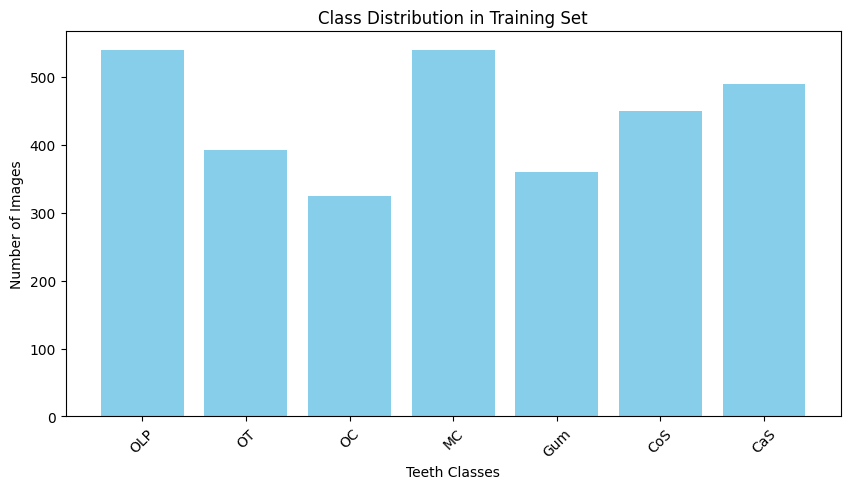

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

classes_in_training = os.listdir(train_dir)
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes_in_training}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Teeth Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()


**4️ Display Sample Images**

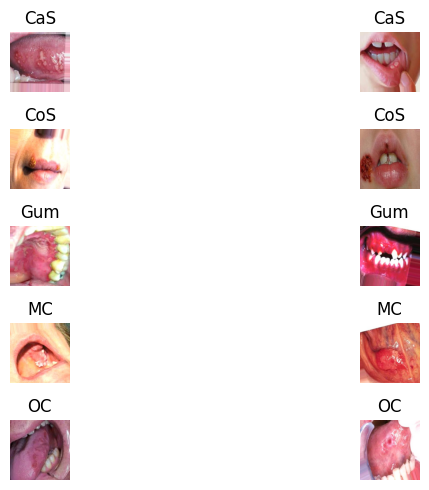

In [8]:
import random
import cv2

# Function to display sample images
def show_sample_images(directory, num_images=2):
    plt.figure(figsize=(10, 5))
    class_labels = sorted(os.listdir(directory))

    for i, category in enumerate(class_labels[:5]):  # Show first 5 classes
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_files = os.listdir(category_path)
            random_images = random.sample(image_files, min(num_images, len(image_files)))

            for j, img_name in enumerate(random_images):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

                plt.subplot(5, num_images, i * num_images + j + 1)
                plt.imshow(img)
                plt.title(category)
                plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display images from training dataset
show_sample_images(train_dir)

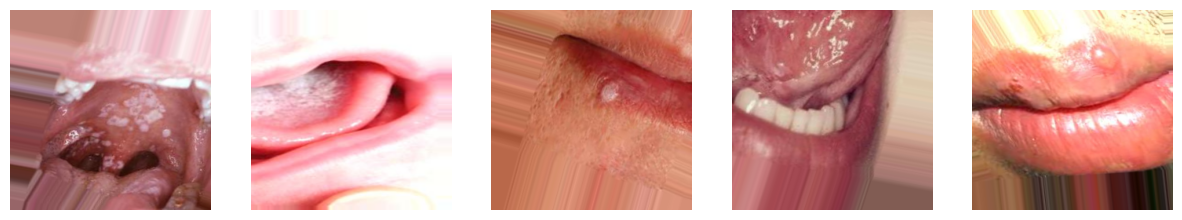

In [9]:
# Get a batch of images
sample_batch, sample_labels = next(train_generator)

# Display images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_batch[i])
    axes[i].axis("off")
plt.show()


# **Step 4: Build the CNN Model**

* We will train a CNN from scratch as required.

** Define Model Architecture**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# To get the number of classes from the train_generator
num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,586,503 (112.86 MB)

 Trainable params: 29,586,503 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

# **Step 5: Train the Model**

**6️ Start Training**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of training steps per epoch
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,  # Number of validation steps
    epochs=34
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 1095s 11s/step - accuracy: 0.1732 - loss: 2.4812 - val_accuracy: 0.2129 - val_loss: 1.9061
Epoch 2/34
 1/96 ━━━━━━━━━━━━━━━━━━━━ 7:23 5s/step - accuracy: 0.0625 - loss: 2.0722

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 681ms/step - accuracy: 0.0625 - loss: 2.0722 - val_accuracy: 0.2949 - val_loss: 1.7882
Epoch 3/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 585s 6s/step - accuracy: 0.2633 - loss: 1.8174 - val_accuracy: 0.3252 - val_loss: 1.7447
Epoch 4/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 673ms/step - accuracy: 0.2188 - loss: 1.8506 - val_accuracy: 0.3281 - val_loss: 1.7382
Epoch 5/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.2999 - loss: 1.7434 - val_accuracy: 0.3545 - val_loss: 1.6297
Epoch 6/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 678ms/step - accuracy: 0.2500 - loss: 1.7061 - val_accuracy: 0.3643 - val_loss: 1.6309
Epoch 7/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.3195 - loss: 1.7078 - val_accuracy: 0.3896 - val_loss: 1.6032
Epoch 8/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 664ms/step - accuracy: 0.3438 - loss: 1.6835 - val_accuracy: 0.3652 - val_loss: 1.6324
Epoch 9/34
96/96 ━━━━━━━━━━━━━━━━━━━━ 684s 7s/step - accuracy: 0.3567 - loss: 1.6516 - val_accuracy: 0.4395 - val_

# **Step 6: Model Evaluation**

> Add blockquote



* Plot accuracy/loss curves.

* Evaluate test set performance.

**7️ Plot Accuracy & Loss Curves**

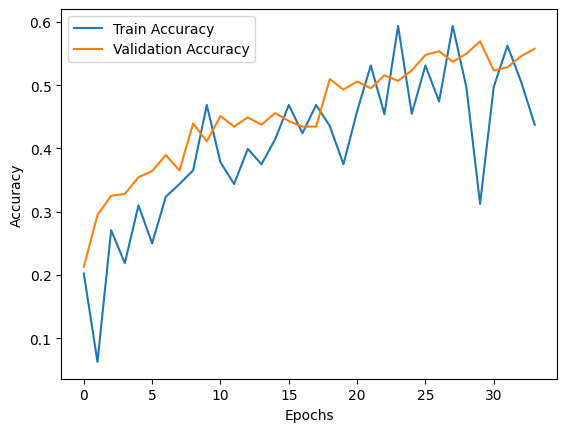

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**8️ Test Model on Unseen Data**

In [ ]:
import tensorflow as tf

# Get the actual number of classes in the test set
num_classes_test = test_generator.num_classes
# Create a new model with the correct output layer
new_model = tf.keras.models.Sequential(model.layers[:-1])  # Copy all layers except the last one
new_model.add(tf.keras.layers.Dense(num_classes_test, activation='softmax'))  # Add a new output layer

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the new model
test_loss, test_acc = new_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 329s 10s/step - accuracy: 0.1214 - loss: 2.2971
Test Accuracy: 11.67%


**9 Confusion Matrix**

33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


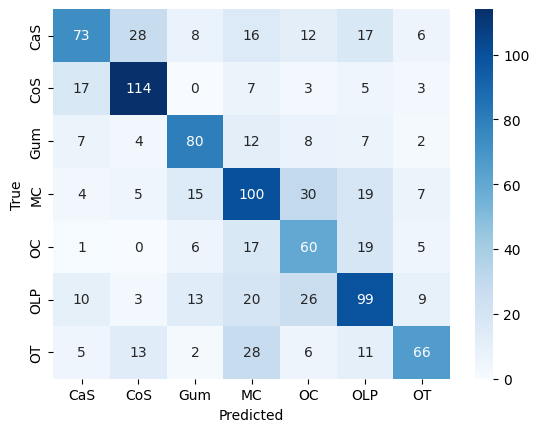

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Fine-Tune a Pretrained Model

We’ll use EfficientNetB0, freeze early layers, and train the last layers.

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


train_dir = "/content/drive/My Drive/Computer_Vision_intern/Teeth_Dataset/Training"
val_dir = "/content/drive/My Drive/Computer_Vision_intern/Teeth_Dataset/Validation"
test_dir = "/content/drive/My Drive/Computer_Vision_intern/Teeth_Dataset/Testing"


# Image parameters
img_size = (224, 224)
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Keep only the required 7 classes in test set
allowed_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', classes=allowed_classes)

# Verify class labels
print("Class Labels:", train_generator.class_indices)


Found 3097 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Class Labels: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


# Build & Train the Model

In [26]:
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


img_size = (128, 128)  # Reduced size for faster training
batch_size = 32

# Data Generators with EfficientNet Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load Pretrained EfficientNetB0 Model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model for initial training

# Custom Layers with Batch Normalization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
output = Dense(7, activation="softmax")(x)

# Compile Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks for Better Training
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Found 3097 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.2625 - loss: 2.0285 - val_accuracy: 0.5253 - val_loss: 1.3747 - learning_rate: 1.0000e-04
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5231 - loss: 1.3254 - val_accuracy: 0.6352 - val_loss: 1.0500 - learning_rate: 1.0000e-04
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5984 - loss: 1.1024 - val_accuracy: 0.7033 - val_loss: 0.8482 - learning_rate: 1.0000e-04
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6687 - loss: 0.9449 - val_accuracy: 0.7539 - val_loss: 0.7036 - learning_rate: 1.0000e-04
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6742 - loss: 0.9026 - val_accuracy: 0.7850 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7342 - loss: 0.7645 - val_accuracy: 0.8171 - val_loss: 0.5479 - learning_rate: 1.0000e-04
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7502 

# Fine-Tuning: Unfreeze last 50 layers

In [29]:

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])


# Fine-Tune the Model

In [33]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights,

)

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6133 - loss: 1.0894 - val_accuracy: 0.8735 - val_loss: 0.4017 - learning_rate: 1.0000e-06
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6246 - loss: 1.0578 - val_accuracy: 0.8152 - val_loss: 0.5730 - learning_rate: 1.0000e-06
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6301 - loss: 1.0434
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
97/97 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6301 - loss: 1.0434 - val_accuracy: 0.7763 - val_loss: 0.6581 - learning_rate: 1.0000e-06
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6567 - loss: 0.9874 - val_accuracy: 0.7617 - val_loss: 0.6965 - learning_rate: 5.0000e-07
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6347 - loss: 1.0169
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
97/97 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6348 - loss: 1.0168

# **Step 7: Save the Model**


**9 Save Model**

In [34]:
model.save("/content/drive/My Drive/Computer_Vision_intern/Final_model.h5")

# streamlit

In [35]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


# Deployment

In [36]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load your model
model_path = "/content/drive/My Drive/Computer_Vision_intern/Final_model.h5"
model = load_model(model_path)

# Define class labels (adjust these based on your dataset)
class_labels = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7"]

# Streamlit UI
st.title("Teeth Classification App 🦷")

uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Load image
    img = image.load_img(uploaded_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]

    # Show image & prediction
    st.image(img, caption="Uploaded Image", use_column_width=True)
    st.write(f"### Prediction: {predicted_class}")


2025-02-17 00:12:23.560 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.688 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-17 00:12:23.689 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.693 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 00:12:23.701 Thread 'MainThread': mi

In [40]:
!streamlit run app.py &>/content/logs.txt &

In [43]:
!pip install pyngrok
!ngrok authtoken YOUR_NGROK_AUTH_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [48]:
!ngrok authtoken 2t96QHFZbWRUerDp2vrJtEVeC7e_6Yc9dh8UxywztMGAGxrXu

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [52]:
from pyngrok import ngrok

ngrok.set_auth_token("2t96QHFZbWRUerDp2vrJtEVeC7e_6Yc9dh8UxywztMGAGxrXu")

public_url = ngrok.connect(addr="8501", proto="http")
print("Access your app here:", public_url)


Access your app here: NgrokTunnel: "https://25ae-35-194-230-82.ngrok-free.app" -> "http://localhost:8501"


# **Thanks**